# SECTION 1: IMPORTS & SETUP
Clear all legacy imports.
Import updated modules and set plot style.

In [7]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
from collections import defaultdict

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from core.quantum_field_engine import QuantumFieldEngine  # For physics verifications
from training.fractal_clustering import FractalClusteringEngine
from training.monte_carlo_engine import ComboResult, IterationResult, TradeResult

plt.style.use('dark_background')
%matplotlib inline


# SECTION 2: LOAD STATE
Load the Pickle files using a robust helper function.

In [8]:
CHECKPOINT_DIR = '../checkpoints'
MC_STATE_PATH = os.path.join(CHECKPOINT_DIR, 'mc_sweep_state.pkl')
PATTERN_LIB_PATH = os.path.join(CHECKPOINT_DIR, 'pattern_library.pkl')

def load_pickle_file(path, data_key=None):
    """Loads a pickle file, optionally extracting a key from the loaded data."""
    path_obj = Path(path)
    if not path_obj.exists():
        print(f"WARNING: {path_obj} not found. Ensure training/simulation has run.")
        return None
    try:
        with path_obj.open('rb') as f:
            content = pickle.load(f)
        
        data = content.get(data_key, content) if data_key else content
        print(f"Loaded {path_obj.name} with {len(data)} entries.")
        return data
    except (pickle.UnpicklingError, EOFError, Exception) as e:
        print(f"Error loading {path_obj}: {e}")
        return None

results_db = load_pickle_file(MC_STATE_PATH, data_key='results_db') or {}
pattern_library = load_pickle_file(PATTERN_LIB_PATH) or {}


Loaded mc_sweep_state.pkl with 20 entries.
Loaded pattern_library.pkl with 113 entries.


# SECTION 3: VISUALIZATION 1 - THE PHYSICS MANIFOLD
Goal: See where our specialized "Templates" live in physics space.
X-Axis: Z-Score (Mean Reversion pressure).
Y-Axis: Momentum (Trend pressure).
Size: Member Count.
Color: Win Rate or Cluster ID.

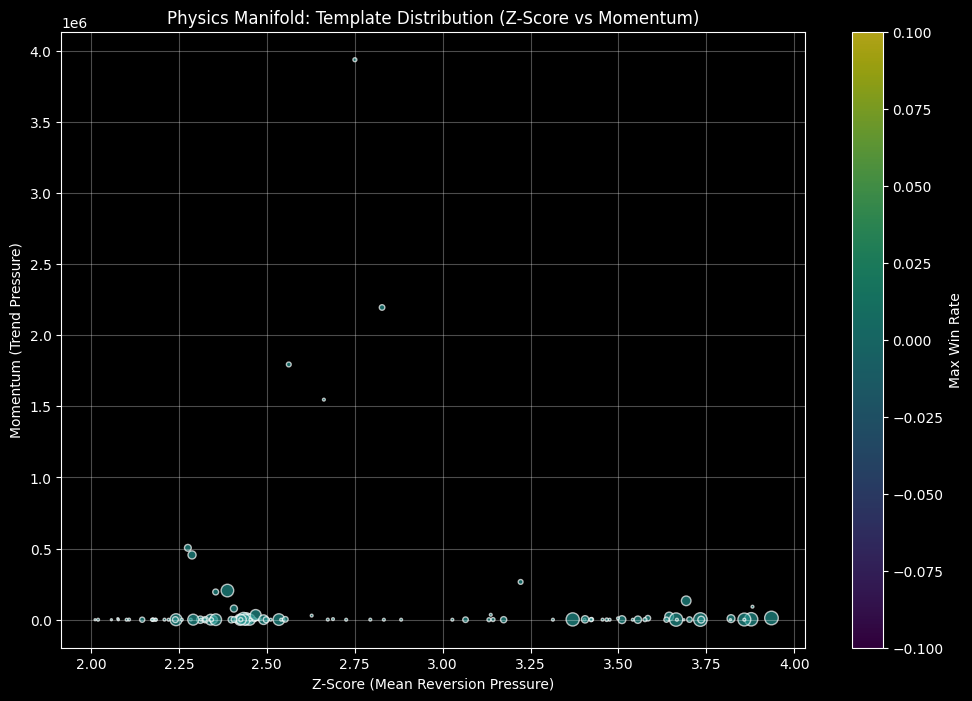

In [9]:
if not pattern_library:
    print("No patterns to visualize.")
else:
    # Pre-group results by template ID for efficient lookup
    results_by_tid = defaultdict(list)
    for (tid, tf), res in results_db.items():
        results_by_tid[tid].append(res)

    data = []
    Z_SCORE_IDX = 0
    MOMENTUM_IDX = 2

    for tid, info in pattern_library.items():
        centroid = info.get('centroid')
        if centroid is None:
            continue
        
        # Centroid: [Z-Score, Velocity, Momentum, Coherence, ...]
        z_score = centroid[Z_SCORE_IDX]
        momentum = centroid[MOMENTUM_IDX]
        member_count = info.get('member_count', 10)
        
        # Try to find win rate from results_db if available
        template_results = results_by_tid.get(tid, [])
        win_rate = max((r.best_win_rate for r in template_results), default=0.0)
        
        data.append({
            'Template_ID': tid,
            'Z_Score': z_score,
            'Momentum': momentum,
            'Member_Count': member_count,
            'Win_Rate': win_rate
        })
    
    df_physics = pd.DataFrame(data)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        df_physics['Z_Score'], 
        df_physics['Momentum'], 
        s=df_physics['Member_Count'] * 2,  # Scale size
        c=df_physics['Win_Rate'], 
        cmap='viridis', 
        alpha=0.7,
        edgecolors='w'
    )
    
    plt.colorbar(scatter, label='Max Win Rate')
    plt.title('Physics Manifold: Template Distribution (Z-Score vs Momentum)')
    plt.xlabel('Z-Score (Mean Reversion Pressure)')
    plt.ylabel('Momentum (Trend Pressure)')
    plt.grid(True, alpha=0.3)
    plt.show()


# SECTION 4: VISUALIZATION 2 - THE FISSION REPORT
Goal: Validate that "Cluster Fission" actually worked.
Identify Templates that share the same "Base ID" and plot their PnL distributions.

In [10]:
# Helper to identify base ID
def get_base_id(tid):
    s_tid = str(tid)
    if len(s_tid) > 2:
        return s_tid[:-1]
    return s_tid

if not results_db:
    print("No simulation results to analyze for fission.")
else:
    # Group results by potential parent
    groups = defaultdict(list)
    for key, result in results_db.items():
        tid = key[0]
        base = get_base_id(tid)
        groups[base].append((tid, result))
    
    # Filter for interesting groups (more than 1 child)
    fission_groups = {k: v for k, v in groups.items() if len(set(x[0] for x in v)) > 1}
    
    # Select top group by total trades or PnL to visualize
    if fission_groups:
        # Pick the group with most variations (unique template IDs)
        best_base = max(fission_groups, key=lambda k: len(set(x[0] for x in fission_groups[k])))
        items = fission_groups[best_base]
        
        # Prepare data for box plot
        plot_data = []
        labels = []
        
        print(f"Visualizing Fission Group for Base ID: {best_base} (Templates: {set(x[0] for x in items)})")
        
        for tid, res in items:
            # Extract PnLs from all iterations (or best iteration trades)
            # We'll use the trades from the best iteration
            if res.iterations:
                best_iter = max(res.iterations, key=lambda i: i.total_pnl)
                pnls = [t.pnl for t in best_iter.trades]
                if pnls:
                    plot_data.append(pnls)
                    labels.append(f"TID {tid}\n({res.timeframe})")
        
        if plot_data:
            plt.figure(figsize=(14, 6))
            plt.boxplot(plot_data, labels=labels)
            plt.title(f'PnL Distribution Comparison: Fission Group {best_base}')
            plt.ylabel('Trade PnL ($)')
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.show()
        else:
            print("No trades found in this group to plot.")
    else:
        print("No obvious fission groups found (based on ID prefix heuristic).")


No obvious fission groups found (based on ID prefix heuristic).


# SECTION 5: VISUALIZATION 3 - MONTE CARLO HEATMAP
Goal: Identify the "Golden Timeframes".
Highlight combinations with Sharpe > 2.0.

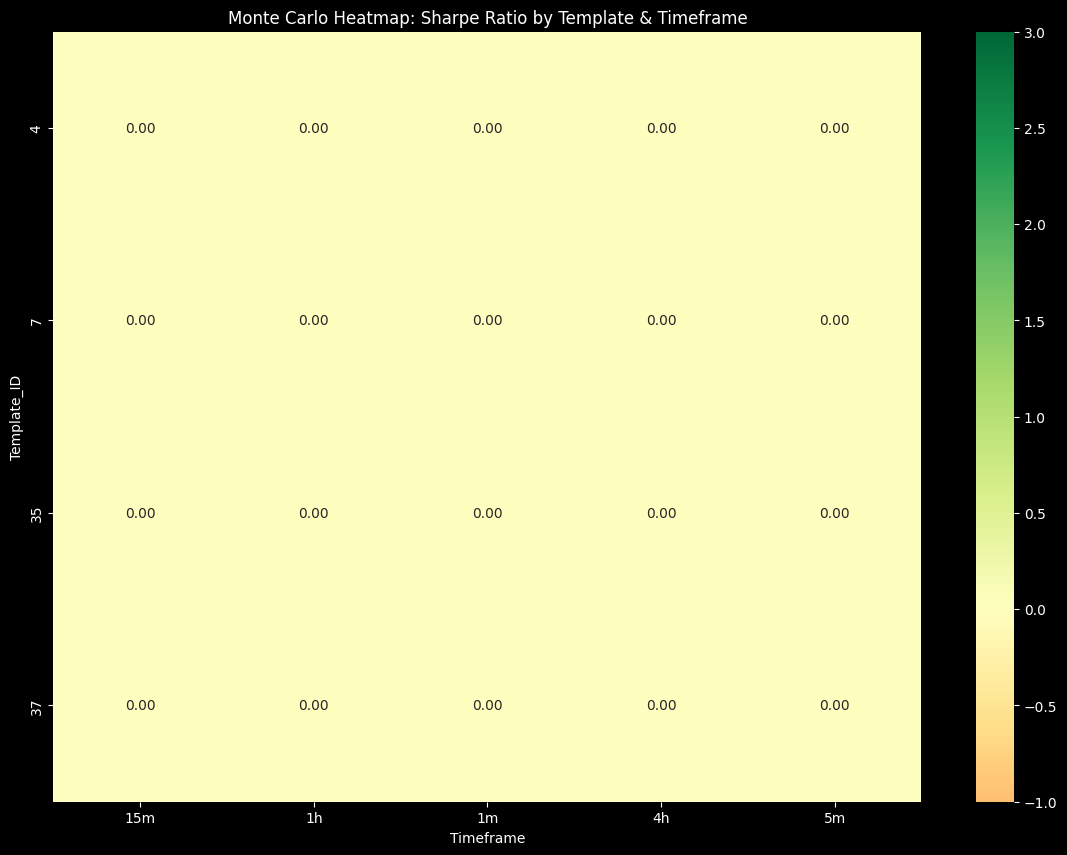


No Golden Timeframes (Sharpe > 2.0) found.


In [11]:
if not results_db:
    print("No results to visualize.")
else:
    heatmap_data = []
    
    for (tid, tf), res in results_db.items():
        # Calculate Sharpe
        sharpe = 0.0
        if res.iterations:
            best_iter = max(res.iterations, key=lambda i: i.total_pnl)
            pnls = [t.pnl for t in best_iter.trades]
            if len(pnls) > 1 and np.std(pnls) > 0:
                sharpe = np.mean(pnls) / np.std(pnls)
        
        heatmap_data.append({
            'Template_ID': tid,
            'Timeframe': tf,
            'Sharpe_Ratio': sharpe,
            'Total_PnL': res.best_pnl
        })
    
    df_hm = pd.DataFrame(heatmap_data)
    
    if not df_hm.empty:
        # Pivot
        pivot_hm = df_hm.pivot(index='Template_ID', columns='Timeframe', values='Sharpe_Ratio')
        
        plt.figure(figsize=(14, 10))
        sns.heatmap(pivot_hm, annot=True, fmt=".2f", cmap='RdYlGn', center=0, vmin=-1, vmax=3)
        plt.title('Monte Carlo Heatmap: Sharpe Ratio by Template & Timeframe')
        plt.show()
        
        # Highlight Golden Timeframes
        GOLDEN_SHARPE_THRESHOLD = 2.0
        golden = df_hm[df_hm['Sharpe_Ratio'] > GOLDEN_SHARPE_THRESHOLD]
        if not golden.empty:
            print("\nGolden Timeframes (Sharpe > 2.0):")
            display(golden[['Template_ID', 'Timeframe', 'Sharpe_Ratio', 'Total_PnL']].sort_values('Sharpe_Ratio', ascending=False))
        else:
            print("\nNo Golden Timeframes (Sharpe > 2.0) found.")
    else:
        print("DataFrame is empty.")


# SECTION 6: PLAYBOOK GENERATION
Goal: Export the final "Cheatsheet" for the trader.
Filter top 10 performing Templates.

In [12]:
if not results_db:
    print("No results to generate playbook.")
else:
    # Flatten results
    playbook_items = []
    Z_SCORE_IDX = 0
    REVERSION_Z_SCORE_THRESHOLD = 2.0
    
    for (tid, tf), res in results_db.items():
        if not res.iterations:
            continue
            
        best_iter = max(res.iterations, key=lambda i: i.total_pnl)
        best_params = res.best_params or {}
        
        # Determine Type (Roche vs Structural)
        p_type = "Unknown"
        if tid in pattern_library:
            centroid = pattern_library[tid]['centroid']
            z = centroid[Z_SCORE_IDX]
            if abs(z) > REVERSION_Z_SCORE_THRESHOLD:
                p_type = "Reversion (Roche)"
            else:
                p_type = "Trend (Structural)"
        
        playbook_items.append({
            'ID': tid,
            'Type': p_type,
            'Best Timeframe': tf,
            'Win Rate': res.best_win_rate,
            'Stop (Ticks)': best_params.get('stop_loss_ticks', 'N/A'),
            'Profit (Ticks)': best_params.get('take_profit_ticks', 'N/A'),
            'Total PnL': res.best_pnl
        })
    
    df_pb = pd.DataFrame(playbook_items)
    
    if not df_pb.empty:
        # Filter top 10 by PnL
        top_10 = df_pb.sort_values('Total PnL', ascending=False).head(10)
        
        print("TOP 10 TRADING PLAYBOOK")
        display(top_10)
    else:
        print("No profitable strategies found.")


TOP 10 TRADING PLAYBOOK


,ID,Type,Best Timeframe,Win Rate,Stop (Ticks),Profit (Ticks),Total PnL
0,37,Reversion (Roche),1m,0.0,19,46,0.0
1,37,Reversion (Roche),5m,0.0,22,35,0.0
18,35,Reversion (Roche),1h,0.0,10,47,0.0
17,35,Reversion (Roche),15m,0.0,19,36,0.0
16,35,Reversion (Roche),5m,0.0,15,46,0.0
15,35,Reversion (Roche),1m,0.0,10,57,0.0
14,4,Reversion (Roche),4h,0.0,17,40,0.0
13,4,Reversion (Roche),1h,0.0,14,35,0.0
12,4,Reversion (Roche),15m,0.0,24,59,0.0
11,4,Reversion (Roche),5m,0.0,10,52,0.0
